# Importing Necessary libraries

In [41]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [42]:
data_path = "energy.csv"
df = pd.read_csv(data_path).drop(columns=["Date and Hour"])
df.head()

,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
0,2020-07-22,20:00:00,21:00:00,Solar,244.0,204,Wednesday,July
1,2020-07-23,07:00:00,08:00:00,Solar,223.0,205,Thursday,July
2,2020-07-23,16:00:00,17:00:00,Solar,2517.0,205,Thursday,July
3,2020-07-23,19:00:00,20:00:00,Solar,658.0,205,Thursday,July
4,2020-07-23,23:00:00,24:00:00,Solar,0.0,205,Thursday,July


# 1. Data Preprocessing


In [43]:
# checking data types
df.dtypes

Date           object
StartHour      object
EndHour        object
Source         object
Production    float64
dayOfYear       int64
dayName        object
monthName      object
dtype: object

In [44]:
df = df.sort_values(by=["Date","StartHour"])
df = df.reindex(list(range(len(df))))
df.isnull().sum()

Date          0
StartHour     0
EndHour       0
Source        0
Production    2
dayOfYear     0
dayName       0
monthName     0
dtype: int64

In [45]:
null_rows = df[df.isnull().any(axis=1)]
null_rows


,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
36164,2022-03-27,02:00:00,03:00:00,Solar,NaN,86,Sunday,March
39321,2022-03-27,02:00:00,03:00:00,Wind,NaN,86,Sunday,March


In [46]:
df = df.fillna(method="ffill")
df.iloc[null_rows.index]

,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
36164,2022-03-27,02:00:00,03:00:00,Solar,4.0,86,Sunday,March
39321,2022-03-27,02:00:00,03:00:00,Wind,7675.0,86,Sunday,March


In [47]:
df["year"] = df.Date.str.split("-", expand=True)[0]

# 2. Exploratory Data Analysis


In [48]:
yearly_production = df.groupby(by=["Source", "year"]).Production.sum().reset_index()
yearly_production

,Source,year,Production
0,Solar,2020,6389965.0
1,Solar,2021,8323800.0
2,Solar,2022,10939292.0
3,Solar,2023,6307001.0
4,Wind,2020,35372922.0
5,Wind,2021,36423417.0
6,Wind,2022,38569740.0
7,Wind,2023,24705728.0


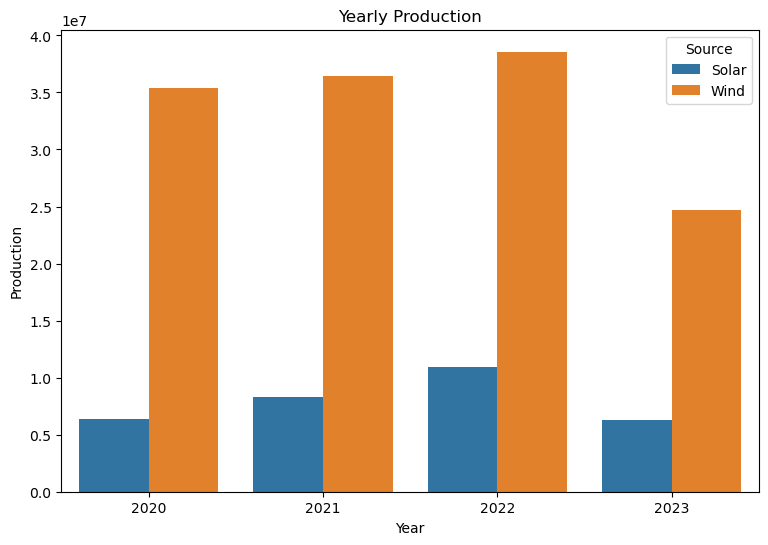

In [10]:
plt.figure(figsize=(9, 6))
sns.barplot(data=yearly_production, x="year", y="Production", hue="Source")
plt.title("Yearly Production")
plt.xlabel("Year")
plt.ylabel("Production")
plt.show()

In [49]:
month_order = {"January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6, "July": 7,
               "August": 8, "September": 9, "October": 10, "November": 11, "December": 12}

In [50]:
year_month_production = df.groupby(by=["Source", "year", "monthName"]).Production.sum().reset_index()
# sorting values based on the months
year_month_production = year_month_production.sort_values(by="monthName", key=lambda x: x.map({m: i for i, m in enumerate(month_order)}))

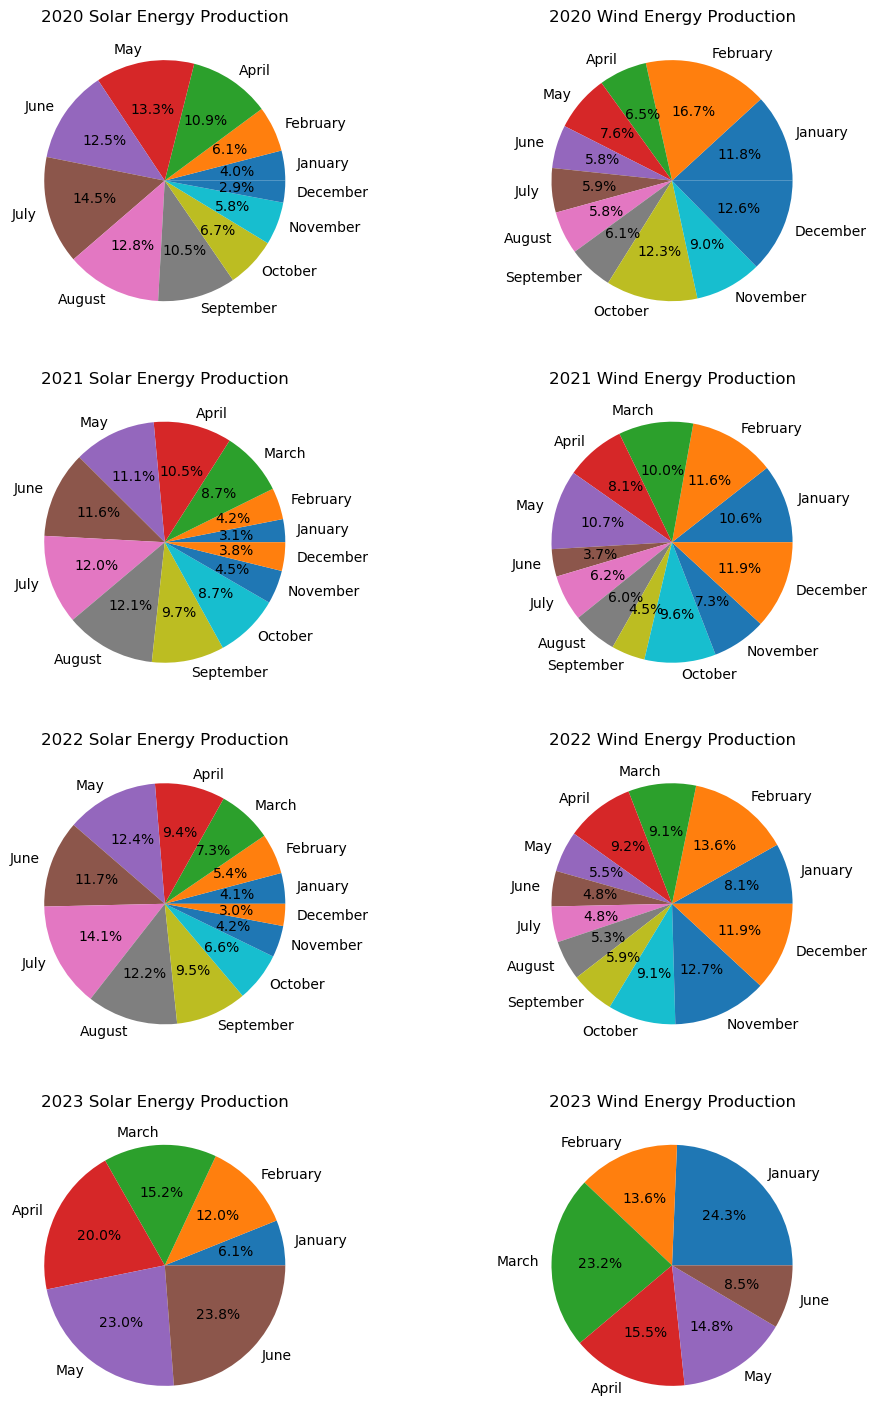

In [51]:
years = sorted(year_month_production.year.unique())

plt.figure(figsize=(12, 18))
plt.subplot(4, 2, 8)

for i, year in enumerate(years):
    
    months = year_month_production[year_month_production.year == year].monthName.unique()
    plt.subplot(4, 2, i*2 + 1)
    
    rule = lambda x: x[x.year == year][x.Source == "Solar"]
    X_solar = rule(year_month_production).Production
    plt.pie(X_solar, labels=months, autopct='%1.1f%%')
    plt.title(f"{year} Solar Energy Production")

    plt.subplot(4, 2, i*2 + 2)
    
    rule = lambda x: x[x.year == year][x.Source == "Wind"]
    X_wind = rule(year_month_production).Production
    plt.pie(X_wind, labels=months, autopct='%1.1f%%')
    plt.title(f"{year} Wind Energy Production")

plt.show()

In [14]:
daily_production = df.groupby(by=["Source","Date"]).Production.sum().reset_index()
daily_production["Date"] = pd.to_datetime(daily_production["Date"])

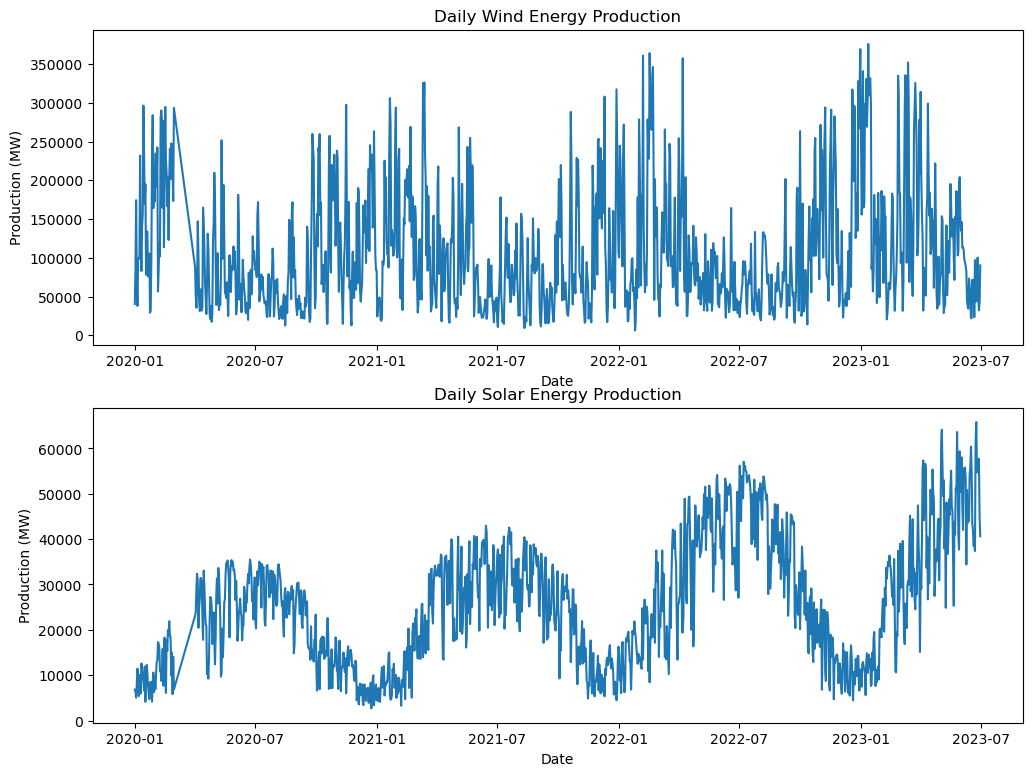

In [15]:
plt.figure(figsize=(12, 9))

plt.subplot(2, 1, 2)

plt.subplot(2, 1, 1)
plt.title("Daily Wind Energy Production")
sns.lineplot(data=daily_production[daily_production.Source=="Wind"], x="Date", y="Production",)
plt.xlabel("Date")
plt.ylabel("Production (MW)")

plt.subplot(2, 1, 2)
plt.title("Daily Solar Energy Production")
sns.lineplot(data=daily_production[daily_production.Source=="Solar"], x="Date", y="Production")
plt.xlabel("Date")
plt.ylabel("Production (MW)")

plt.show()

# 3. Model Selection and Building


In [16]:
# cutting January and February 2020 values from the whole data
cuted_daily_production = daily_production[daily_production.Date >= "2020-04-01"]
cuted_daily_production.set_index("Date", inplace=True, drop=True)

In [17]:
test_size = 150 # Predicting the last "test_size" values

# MinMaxScalers for scaling the production values into the [0, 1] range
Solar_scaler = MinMaxScaler(feature_range=(0, 1))
Wind_scaler = MinMaxScaler(feature_range=(0, 1))

# fitting the Scalers to the WHOLE data (including January and February 2020)
Solar_scaler.fit(daily_production[daily_production.Source == "Solar"][-test_size::-1].Production.values.reshape(-1, 1))
Wind_scaler.fit(daily_production[daily_production.Source == "Wind"][-test_size::-1].Production.values.reshape(-1, 1))

# Transforming the cuted data
Solar_data = Solar_scaler.transform(cuted_daily_production[cuted_daily_production.Source == "Solar"][-test_size::-1].Production.values.reshape(-1, 1))
Wind_data = Wind_scaler.transform(cuted_daily_production[cuted_daily_production.Source == "Wind"][-test_size::-1].Production.values.reshape(-1, 1))

In [18]:
# A function for creating dataset for the model to work with
# returns "X" of shape (num_batch, x_batch_size, 1), "y" of shape (num_batch, y_batch_size, 1)
def create_dataset(target, x_size, y_size):
    X = []
    y = []
    
    x_start = 0
    x_end = x_start + x_size
    y_start = x_end
    y_end = y_start + y_size
    
    for _ in range(len(target)):
        if y_end < len(target):
            X.append(target[x_start:x_end])
            y.append(target[y_start:y_end])
        
        x_start += 1
        x_end = x_start + x_size
        y_start += 1
        y_end = y_start + y_size
    
    return np.array(X), np.array(y)

# 4. Model Training and Evaluation

In [19]:
x_size = 30
y_size = 4
Solar_x, Solar_y = create_dataset(Solar_data, x_size, y_size)
Wind_x, Wind_y = create_dataset(Wind_data, x_size, y_size)

In [20]:
Solar_y = Solar_y.reshape(Solar_y.shape[0], Solar_y.shape[1])
Wind_y = Wind_y.reshape(Wind_y.shape[0], Wind_y.shape[1])

Solar_x.shape, Solar_y.shape, Wind_x.shape, Wind_y.shape

((1003, 30, 1), (1003, 4), (1003, 30, 1), (1003, 4))

In [21]:
# A function for creating LSTM model
def create_LSTM_model(x_size, y_size):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input((x_size, 1)),
        tf.keras.layers.LSTM(512),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(y_size, activation="sigmoid")
    ])

    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
    return model

In [57]:
# custom log printer for printing log lines every 50 epoch
class PrintLossCallback(tf.keras.callbacks.Callback):
    def __init__(self, logpath):
        self.logpath = logpath
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 50 == 0:
            print(f'Epoch {epoch}: Loss = {np.round(logs["loss"], 5)} | Accuracy = {np.round(logs["accuracy"], 5)}')
            
log_path = "log.txt"
callbacks=[PrintLossCallback(log_path)]

In [56]:
Solar_model = create_LSTM_model(x_size, y_size)
Solar_model.fit(x=Solar_x, y=Solar_y, epochs=300, batch_size=8, callbacks=callbacks, verbose=0)

Epoch 0: Loss = 0.02815 | Accuracy = 0.25823
Epoch 50: Loss = 0.01281 | Accuracy = 0.32602
Epoch 100: Loss = 0.00783 | Accuracy = 0.38684
Epoch 150: Loss = 0.00439 | Accuracy = 0.5324
Epoch 200: Loss = 0.00292 | Accuracy = 0.59521
Epoch 250: Loss = 0.0023 | Accuracy = 0.65005


In [58]:
Wind_model = create_LSTM_model(x_size, y_size)
Wind_model.fit(x=Wind_x, y=Wind_y, epochs=200, batch_size=8, callbacks=callbacks, verbose=0)

Epoch 0: Loss = 0.04197 | Accuracy = 0.25424
Epoch 50: Loss = 0.02379 | Accuracy = 0.36989
Epoch 100: Loss = 0.00789 | Accuracy = 0.54536
Epoch 150: Loss = 0.00365 | Accuracy = 0.68893


### Testing 

In [59]:
Wind_model = create_LSTM_model(x_size, y_size)
Wind_model.fit(x=Wind_x, y=Wind_y, epochs=40, batch_size=8, callbacks=callbacks, verbose=0)

Epoch 0: Loss = 0.04378 | Accuracy = 0.27717


In [28]:
Solar_test_pred = Solar_model.predict(Solar_test_x)
Wind_test_pred = Wind_model.predict(Wind_test_x)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


In [29]:
Solar_test_pred = Solar_scaler.inverse_transform(Solar_test_pred)
Wind_test_pred = Wind_scaler.inverse_transform(Wind_test_pred)

In [30]:
# Creating data frames from the predicted values for plotting conveniency
df_solar_pred = pd.DataFrame(columns=["Date", "Production"])
df_solar_pred.Date = cuted_daily_production[cuted_daily_production.Source == "Solar"][-len(Solar_test_pred)::+1].index
df_solar_pred.Production = Solar_test_pred[:, 0]
df_solar_pred["Date"] = pd.to_datetime(df_solar_pred["Date"])

df_wind_pred = pd.DataFrame(columns=["Date", "Production"])
df_wind_pred.Date = cuted_daily_production[cuted_daily_production.Source == "Wind"][-len(Wind_test_pred)::+1].index
df_wind_pred.Production = Wind_test_pred[:, 0]
df_wind_pred["Date"] = pd.to_datetime(df_wind_pred["Date"])

### Results

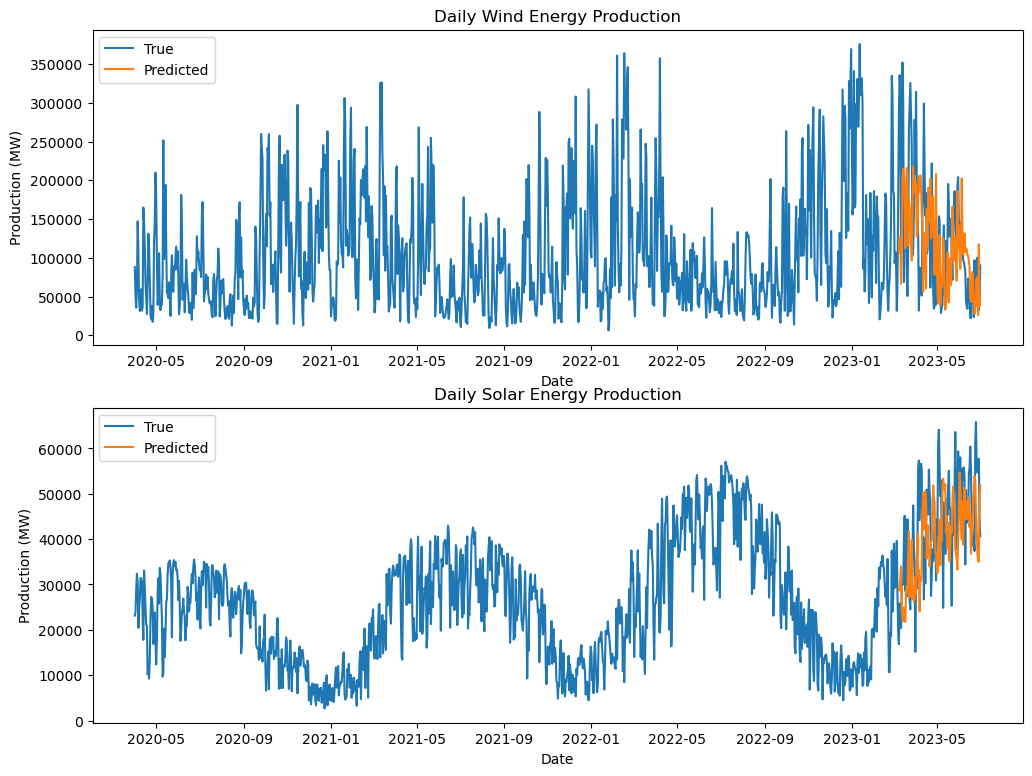

In [31]:
plt.figure(figsize=(12, 9))

plt.subplot(2, 1, 2)

plt.subplot(2, 1, 1)
plt.title("Daily Wind Energy Production")
sns.lineplot(data=cuted_daily_production[cuted_daily_production.Source=="Wind"],
             x="Date", y="Production", label="True")
sns.lineplot(data=df_wind_pred, x="Date", y="Production", label="Predicted")
plt.xlabel("Date")
plt.ylabel("Production (MW)")

plt.subplot(2, 1, 2)
plt.title("Daily Solar Energy Production")
sns.lineplot(data=cuted_daily_production[cuted_daily_production.Source=="Solar"],
             x="Date", y="Production", label="True")
sns.lineplot(data=df_solar_pred, x="Date", y="Production", label="Predicted")
plt.xlabel("Date")
plt.ylabel("Production (MW)")

plt.show()

# 5. Hyperparameter Tuning

Trial 10 Complete [00h 03m 53s]
val_loss: 0.011084704659879208

Best val_loss So Far: 0.010703273117542267
Total elapsed time: 00h 25m 09s
The best hyperparameters are: {'units': 352, 'dense_units_1': 384, 'dropout_1': 0.2, 'dense_units_2': 256, 'dropout_2': 0.4, 'learning_rate': 0.001791969685438558}
Epoch 1/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.2303 - loss: 0.0506 - val_accuracy: 0.3284 - val_loss: 0.0121
Epoch 2/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.2192 - loss: 0.0208 - val_accuracy: 0.3383 - val_loss: 0.0127
Epoch 3/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.2595 - loss: 0.0176 - val_accuracy: 0.2488 - val_loss: 0.0143
Epoch 4/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.2275 - loss: 0.0180 - val_accuracy: 0.2935 - val_loss: 0.0124
Epoch 5/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.2661 - loss: 0.0172 - val_accuracy: 0.3532 - val_loss: 0.0135
Epoch 6/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy:

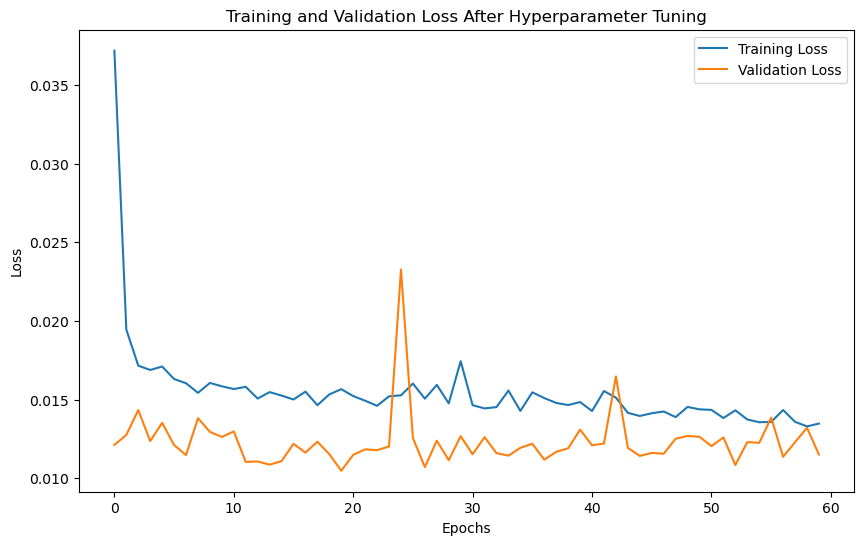

In [54]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

# Define the model for hyperparameter tuning
def build_model(hp):
    model = tf.keras.Sequential()

    # Adding LSTM layer with tunable number of units
    model.add(tf.keras.layers.LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), 
                                   input_shape=(x_size, 1)))
    
    # Adding Dense layers with tunable number of neurons
    model.add(tf.keras.layers.Dense(units=hp.Int('dense_units_1', min_value=64, max_value=512, step=64),
                                    activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(tf.keras.layers.Dense(units=hp.Int('dense_units_2', min_value=32, max_value=256, step=32),
                                    activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer with number of units equal to output size (y_size)
    model.add(tf.keras.layers.Dense(units=y_size, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='mse', 
                  metrics=['accuracy'])

    return model

# Create a Keras Tuner instance for Random Search
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',  # We aim to minimize validation loss
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times to train each model
    directory='hyperparam_tuning',
    project_name='energy_forecasting'
)

# Split the dataset for training and validation
split_ratio = 0.8
split_idx = int(len(Solar_x) * split_ratio)

# Solar energy data
Solar_x_train, Solar_x_val = Solar_x[:split_idx], Solar_x[split_idx:]
Solar_y_train, Solar_y_val = Solar_y[:split_idx], Solar_y[split_idx:]

# Run hyperparameter search for Solar energy model
tuner.search(Solar_x_train, Solar_y_train, epochs=50, validation_data=(Solar_x_val, Solar_y_val), batch_size=8)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print(f"The best hyperparameters are: {best_hps.values}")

# Train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(Solar_x_train, Solar_y_train, epochs=60, validation_data=(Solar_x_val, Solar_y_val))

# Plot training vs validation loss to observe the model’s performance
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss After Hyperparameter Tuning")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
